In [25]:
import warnings

warnings.simplefilter('ignore')

%matplotlib inline
from seaborn import apionly as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

import matplotlib.ticker as plticker

plt.style.use(['seaborn-whitegrid', 'seaborn-ticks'])

rcParams['figure.figsize'] = 8, 6
rcParams['axes.facecolor'] = 'FFFFFF'
rcParams['savefig.facecolor'] = 'FFFFFF'
rcParams['figure.facecolor'] = 'FFFFFF'

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'

rcParams.update({'figure.autolayout': True})

# %config InlineBackend.figure_format = 'retina'

import numpy as np

import tensorflow as tf
print(f'TF Version: {tf.__version__}')

import tensorflow_probability as tfp
tfd = tfp.distributions

from corner import corner

TF Version: 2.1.0


Make some dummy data, $x\sim Gaussian(\mu = 5, \sigma = 1)$

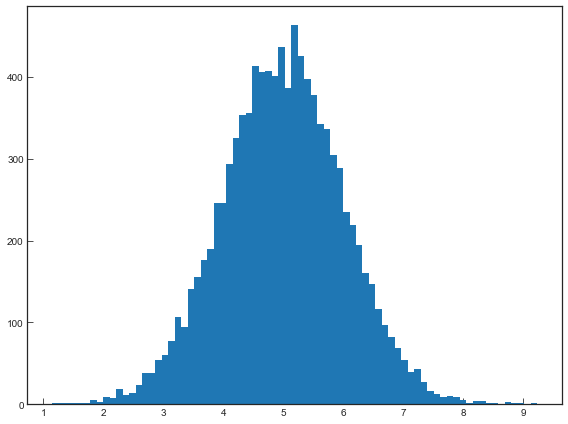

In [4]:
data = np.random.normal(5, 1, size = 10000);
plt.hist(data, 75);

Make a model with two parameters (mean and width), with uniform priors in the range $[-10, 10]$ and $[0, 10]$

```Python
rv_mean * tf.ones(len(data), 1)
```

is required to reshape this to the data size (it feels like this shouldn't be necessary?).

In [5]:
from tensorflow_probability import edward2 as ed

def res_model():
    
    rv_mean = ed.Uniform(low=-10.0, high=10.0, name = 'rv_mean')
    rv_width = ed.Uniform(low=0.0, high=10.0, name = 'rv_width')
    
    obs = ed.Normal(loc = rv_mean * tf.ones(len(data), 1), scale = rv_width, name = 'obs')
    
    return obs

log_joint = ed.make_log_joint_fn(res_model)

def target_log_prob_fn(mean, width):
    return log_joint(rv_mean = mean, rv_width = width, obs = data)

Initialise chains with $\mu_0 = 0.0$ and $\sigma_0 = 1.0$

In [16]:
initial_chain_state = [
    0.0 * tf.ones([], dtype=tf.float32, name="init_rv_mean"),
    1.0 * tf.ones([], dtype=tf.float32, name="init_rv_width"),
]

Run the sampler for $10,000$ steps with $1,000$ steps of burn in

In [17]:
num_results = 10000
num_burnin_steps = 1000

Configure the Hamiltonian Monte Carlo sampler, with an adaptive step size, and run

In [18]:
@tf.function(autograph=False, experimental_compile=True) # Compile this with XLA
def do_sampling():

  kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      step_size=0.1,
      num_leapfrog_steps=10)

  kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_chain_state,
      kernel=kernel,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

(mean_, width_), is_accepted_ = do_sampling()

`mean_` and `width_` are samples from the Markov Chain of length `num_results`. We can discard the first $\sim1000$ samples in which the chain took time to equilibrate.

We use `is_accepted_` to take only the samples that were accepted by the Markov Chain.

In [19]:
meanSamples = mean_[is_accepted_][1000:]
widthSamples = width_[is_accepted_][1000:]

Plot the value of the sample at each iteration

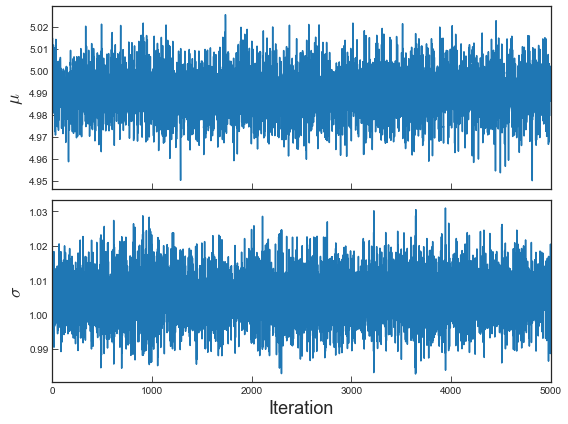

In [20]:
fig, ax = plt.subplots(2, 1, sharex = 'col')

ax[0].plot(meanSamples);
ax[0].set_ylabel(r'$\mu$', fontsize = 18);
ax[0].set_xlim(0, 5000);

ax[1].plot(widthSamples);
ax[1].set_ylabel(r'$\sigma$', fontsize = 18);
ax[1].set_xlabel('Iteration', fontsize = 18);

...and histograms of these distributions

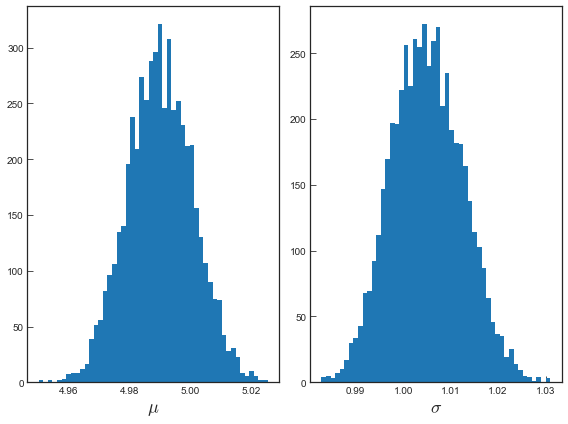

In [21]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(meanSamples, bins = 50);
ax[0].set_xlabel(r'$\mu$', fontsize = 18);

ax[1].hist(widthSamples, bins = 50);
ax[1].set_xlabel(r'$\sigma$', fontsize = 18);

We can see that they are distributed around our generated values of $5$ and $1$!

Each index of the output chain for each parameter corresponds to the index in the others, so we can plot the multidimensional distribution of these.

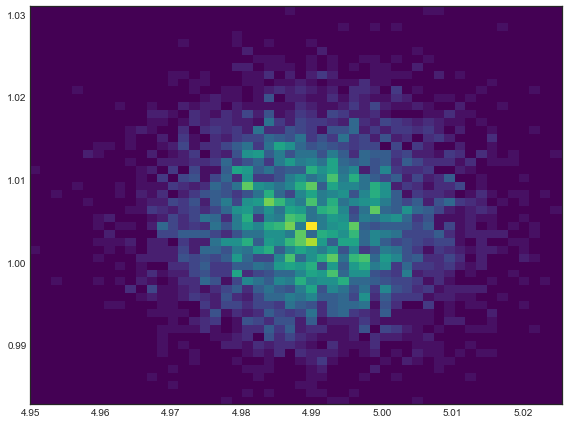

In [22]:
plt.hist2d(meanSamples, widthSamples, bins = 50, cmap = 'viridis');

We can also use a cool package that makes a 'corner' plot, that displays the pairwise joint distribution of each pair of variables, and the marginal distributions.

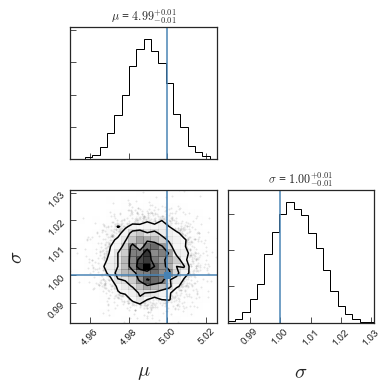

In [23]:
cornerData = np.vstack([meanSamples, widthSamples]).T
corner(cornerData, labels = [r'$\mu$', r'$\sigma$'], label_kwargs=dict(fontsize=20), show_titles = True, truths = [5.0, 1.0]);